# The Goal of the Project

The aim of this study is to apply nonlinear regression models to the "Hitters" dataset and compare the models. Also in this dataset, the model that gives the best results for the estimation of player salaries has been determined.

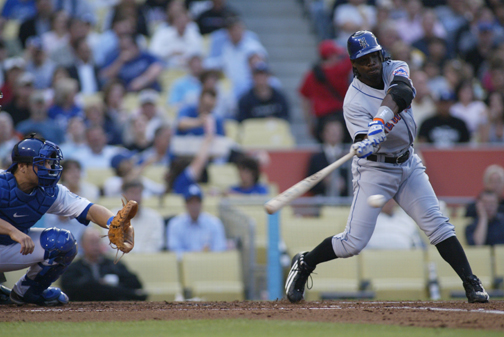

### Dataset Information: 

This dataset was originally taken from the StatLib library which is maintained at Carnegie Mellon University. This is part of the data that was used in the 1988 ASA Graphics Section Poster Session. The salary data were originally from Sports Illustrated, April 20, 1987. The 1986 and career statistics were obtained from The 1987 Baseball Encyclopedia Update published by Collier Books, Macmillan Publishing Company, New York.

Link to the Data Set: https://www.kaggle.com/floser/hitters

### Attribute Information:

A data frame with 322 observations of major league players on the following 20 variables.

- AtBat: Number of times at bat in 1986
- Hits: Number of hits in 1986
- HmRun: Number of home runs in 1986
- Runs: Number of runs in 1986
- RBI: Number of runs batted in in 1986
- Walks: Number of walks in 1986
- Years: Number of years in the major leagues
- CAtBat: Number of times at bat during his career
- CHits: Number of hits during his career
- CHmRun: Number of home runs during his career
- CRuns: Number of runs during his career
- CRBI: Number of runs batted in during his career
- CWalks: Number of walks during his career
- League: A factor with levels A and N indicating player’s league at the end of 1986
- Division: A factor with levels E and W indicating player’s division at the end of 1986
- PutOuts: Number of put outs in 1986
- Assists: Number of assists in 1986
- Errors: Number of errors in 1986
- Salary: 1987 annual salary on opening day in thousands of dollars
- NewLeague: A factor with levels A and N indicating player’s league at the beginning of 1987

# Installation of Libraries

In [ ]:
import numpy as np
import pandas as pd 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import neighbors
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

from warnings import filterwarnings
filterwarnings('ignore')

# Data Preproccesing

In [ ]:
def data_prep():
    df = pd.read_csv("../input/hitters/Hitters.csv") #calling the dataset

    #we added variables that would enable our models to explain better
    #values of some variables on year basis
    df["Mean_CAtBat"] = df["CAtBat"] / df["Years"]
    df["Mean_CHits"] = df["CHits"] / df["Years"]
    df["Mean_CHmRun"] = df["CHmRun"] / df["Years"]
    df["Mean_Cruns"] = df["CRuns"] / df["Years"]
    df["Mean_CRBI"] = df["CRBI"] / df["Years"]
    df["Mean_CWalks"] = df["CWalks"] / df["Years"]

    #variables that affect the model less were removed from the dataset
    df = df.drop(['AtBat','Hits','HmRun','Runs','RBI','Walks','Assists',
                  'Errors',"PutOuts",'League','NewLeague', 'Division'], axis=1)

    #missing data filled in according to KNN
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors = 4)
    df_filled = imputer.fit_transform(df)
    df = pd.DataFrame(df_filled,columns = df.columns)

    #Suppression for contradictory observations in Salary variable
    Q1 = df.Salary.quantile(0.25)
    Q3 = df.Salary.quantile(0.75)
    IQR = Q3-Q1
    lower = Q1 - 1.5*IQR
    upper = Q3 + 1.5*IQR
    df.loc[df["Salary"] > upper,"Salary"] = upper
    
    y = df["Salary"]
    X = df.drop("Salary",axis=1)
    
    #standardizing distributions
    from sklearn.preprocessing import RobustScaler
    scaler = RobustScaler()
    X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.20, 
                                                        random_state=46)
    
    return X_train, X_test, y_train, y_test

# Modeling

In [ ]:
def modeling(X_train, X_test, y_train, y_test):
    #KNN
    
    knn_params = {'n_neighbors': 6}

    knn_tuned = KNeighborsRegressor(**knn_params).fit(X_train, y_train)
    
    #test error
    y_pred = knn_tuned.predict(X_test)
    knn_final = np.sqrt(mean_squared_error(y_test, y_pred))
    print("final rmse KNN")
    print(knn_final)
    
    #SVR
    svr_params = {'C': 1000}

    svr_tuned = SVR(**svr_params).fit(X_train, y_train)
    
    #test error
    y_pred = svr_tuned.predict(X_test)
    svr_final = np.sqrt(mean_squared_error(y_test, y_pred))
    print("final rmse SVR")
    print(svr_final)
    
    #CART
    cart_params = {'max_depth': 5, 'min_samples_split': 50}
    
    cart_tuned = DecisionTreeRegressor(**cart_params).fit(X_train, y_train)
    
    #test error
    y_pred = cart_tuned.predict(X_test)
    cart_final = np.sqrt(mean_squared_error(y_test, y_pred))
    print("final rmse CART")
    print(cart_final)
    
    
    #RANDOM FOREST
    rf_params = {'max_depth': 5, 'max_features': 2, 'min_samples_split': 2, 'n_estimators': 900}

    rf_tuned = RandomForestRegressor(**rf_params).fit(X_train, y_train)

    #test error
    y_pred = rf_tuned.predict(X_test)
    rf_final = np.sqrt(mean_squared_error(y_test, y_pred))
    print("final rmse RF")
    print(rf_final)
    
    #GBM
    
    gbm_params = {'learning_rate': 0.01,
    'loss': 'lad', 
    'max_depth': 5,
    'n_estimators': 500,
    'subsample': 0.5}
    
    gbm_tuned = GradientBoostingRegressor(**gbm_params).fit(X_train, y_train)

    #test error
    y_pred = gbm_tuned.predict(X_test)
    gbm_final = np.sqrt(mean_squared_error(y_test, y_pred))
    print("final rmse GBM")
    print(gbm_final)
    
    #XGBoost    
    xgb_params = {'colsample_bytree': 1,
    'learning_rate': 0.01,
    'max_depth': 2,
    'n_estimators': 500}
    
    xgb_tuned = XGBRegressor(**xgb_params).fit(X_train, y_train)
    
    y_pred = xgb_tuned.predict(X_test)
    xgb_final = np.sqrt(mean_squared_error(y_test, y_pred))
    print("final rmse XGBoost")
    print(xgb_final)
    
    #Light GBM
    lgbm_params = {'colsample_bytree': 1,
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 200}
    
    lgbm_tuned = LGBMRegressor(**lgbm_params).fit(X_train, y_train)
    
    y_pred = lgbm_tuned.predict(X_test)
    lbg_final = np.sqrt(mean_squared_error(y_test, y_pred))
    print("final rmse LightGBM")
    print(lbg_final)
    
    #CatBoost
    catb_params = {'depth': 10, 'iterations': 500, 'learning_rate': 0.1}
    
    catb_tuned = CatBoostRegressor(**catb_params).fit(X_train, y_train)
    
    y_pred = catb_tuned.predict(X_test)
    cat_final = np.sqrt(mean_squared_error(y_test, y_pred))
    print("final rmse CatBoost")
    print(cat_final)
    
    #Neural Networks
    mlp_params = {'alpha': 0.1, 'hidden_layer_sizes': (1000, 100, 10)}
    
    mlp_tuned = MLPRegressor(**mlp_params).fit(X_train, y_train)
    
    y_pred = mlp_tuned.predict(X_test)
    neural_final = np.sqrt(mean_squared_error(y_test, y_pred))
    print("final rmse Neural Networks")
    print(neural_final)
    
    results = pd.DataFrame({"Test Tuned Error":[knn_final, svr_final, cart_final, 
                                                rf_final,gbm_final, xgb_final, 
                                                lbg_final, cat_final, neural_final]})
    results.index= ["KNN", "SVR","CART","Random Forests","GBM","XGBoost", "LightGBM", 
                    "CatBoost", "Neural Networks"]
    print(results)

In [ ]:
X_train, X_test, y_train, y_test = data_prep()

In [ ]:
modeling(X_train, X_test, y_train, y_test)

# **Conclusion**

  - Our aim is to compare the models and minimize error scores for dataset. This was done with two functions.
    
  - Data preprocessing and modeling were defined by two functions. We run all processes and models with two functions. We have given the values we obtained in data preprocessing as an input to the modeling function. So we got the modeling results.
    
  - Hitters Data Set read.
  
  - NA values filled with the KNN algorithm.
  
  - X variables standardized with RobustScaler.
  
  - Predetermined optimum values are assigned as hyperparameter values for each model.
    
  - It was determined that the model with the least rmse in the dataset was the GBM model.

# Resources

- https://www.kaggle.com/ahmetcankaraolan/salary-predict-with-nonlinear-regression-models

- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html